In [294]:
# 라이브러리 불러오기
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import numpy as np

%matplotlib inline
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

In [295]:
# 종목 데이터 불러오기

df = fdr.DataReader('055550','2000-12-01')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2001-09-10,10797,11324,9885,10894,1254910,NaN
2001-09-11,11037,11277,10894,11181,1239210,0.026345
2001-09-12,9549,10509,9549,9694,1468150,-0.132993
2001-09-13,10173,10749,10029,10366,1916800,0.069321
2001-09-14,10077,10317,9549,9742,1323690,-0.060197
...,...,...,...,...,...,...
2021-08-23,37550,37950,37200,37450,1113380,0.009434
2021-08-24,37850,38650,37750,38650,1262833,0.032043
2021-08-25,38350,38950,38200,38950,1114072,0.007762


In [296]:
# 불린저밴드 함수 만들기

n = 20
sigma = 2
def bollinger_band(df,n,sigma):
    bb = df.copy()
    bb['center'] = df['Close'].rolling(n).mean()
    bb['ub'] = bb['center'] + sigma * df['Close'].rolling(n).std()
    bb['lb'] = bb['center'] - sigma * df['Close'].rolling(n).std()
    bb = bb.loc[:,['Close','ub','center','lb']]
    return bb
bollinger = bollinger_band(df,n,sigma)

In [297]:
# 수익률의 기준이 되는 날짜 base_date =

base_date = '2010-01-02'
sample = bollinger.loc[base_date:]

In [298]:
# 거래내역 칼럼


book = sample[['Close']].copy()
book['trade'] = ''
book

,Close,trade
Date,,
2010-01-04,43600,
2010-01-05,44600,
2010-01-06,44950,
2010-01-07,43600,
2010-01-08,44450,
...,...,...
2021-08-23,37450,
2021-08-24,38650,
2021-08-25,38950,


In [299]:
# 거래 전략

def tradings(sample,book):
    for i in sample.index:
        if sample.loc[i, 'Close'] > sample.loc[i, 'ub']:
            book.loc[i,'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Close']:
            if book.shift(1).loc[i,'trade'] == 'buy':
                book.loc[i,'trade'] = 'buy'
            else:
                book.loc[i,'trade'] = 'buy'
        elif sample.loc[i,'ub'] >= sample.loc[i,'Close'] and sample.loc[i, 'Close'] >= sample.loc[i, 'lb']:
            if book.shift(1).loc[i,'trade'] == 'buy':
                book.loc[i,'trade'] = 'buy'
            else:
                book.loc[i, 'trade'] = ''
    return (book)

In [300]:
# 위 함수를 실행한다.
book =tradings(sample,book)
book['daily_rtn'] = book['Close'].pct_change()
book['st_rtn'] = (1+book['daily_rtn']).cumprod()
book

,Close,trade,daily_rtn,st_rtn
Date,,,,
2010-01-04,43600,,NaN,NaN
2010-01-05,44600,,0.022936,1.022936
2010-01-06,44950,,0.007848,1.030963
2010-01-07,43600,,-0.030033,1.000000
2010-01-08,44450,,0.019495,1.019495
...,...,...,...,...
2021-08-23,37450,buy,0.009434,0.858945
2021-08-24,38650,buy,0.032043,0.886468
2021-08-25,38950,buy,0.007762,0.893349


In [301]:
# 수익률 계산함수를 만들자.

def returns(book):
    rtn = 1.0
    book['return'] = 1.0
    buy = 0.0
    sell = 0.0
    for i in book.index:
        # long 진입
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':
            buy = book.loc[i, 'Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        # long 청산
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':
            sell =book.loc[i,'Close']
            rtn =(sell-buy) /buy + 1 #손익계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy,' : long 청산가격 ',\
                 sell,' : return:',round(rtn,4))
            
    if book.loc[i,'trade'] == '':
        buy = 0.0
        sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i,'return']
        acc_rtn = acc_rtn * rtn
        book.loc[i,'acc return'] = acc_rtn
    print('Accumulated return :', round(acc_rtn,4))
    return (round(acc_rtn,4))

In [302]:
print(returns(book))

진입일 :  2010-01-18 00:00:00 long 진입가격 :  42000
청산일 :  2010-03-08 00:00:00 long 진입가격 :  42000  : long 청산가격  44550  : return: 1.0607
진입일 :  2010-05-06 00:00:00 long 진입가격 :  45400
청산일 :  2010-10-01 00:00:00 long 진입가격 :  45400  : long 청산가격  45950  : return: 1.0121
진입일 :  2010-11-11 00:00:00 long 진입가격 :  41950
청산일 :  2010-12-06 00:00:00 long 진입가격 :  41950  : long 청산가격  47000  : return: 1.1204
진입일 :  2011-01-21 00:00:00 long 진입가격 :  49550
청산일 :  2011-04-04 00:00:00 long 진입가격 :  49550  : long 청산가격  51500  : return: 1.0394
진입일 :  2011-08-08 00:00:00 long 진입가격 :  46250
청산일 :  2011-10-07 00:00:00 long 진입가격 :  46250  : long 청산가격  44800  : return: 0.9686
진입일 :  2011-11-10 00:00:00 long 진입가격 :  38600
청산일 :  2012-01-19 00:00:00 long 진입가격 :  38600  : long 청산가격  42950  : return: 1.1127
진입일 :  2012-04-06 00:00:00 long 진입가격 :  43300
청산일 :  2012-06-15 00:00:00 long 진입가격 :  43300  : long 청산가격  40700  : return: 0.94
진입일 :  2012-07-23 00:00:00 long 진입가격 :  34100
청산일 :  2012-09-17 00:00:00 long 진입가격 :  34100 

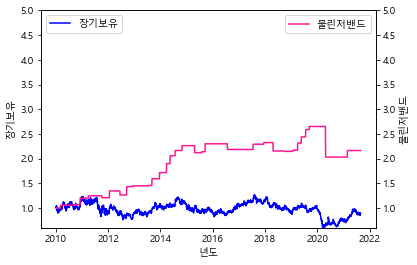

In [303]:
x = book.index
y1 = book['st_rtn']
y2 = book['acc return']

fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='blue', label= '장기보유')
ax1.set_xlabel('년도')
ax1.set_ylabel('장기보유')
ax1.legend(loc=2)
ax1.set_ylim(0.6,5)

ax2 = ax1.twinx()
ax2.plot(x, y2, color='deeppink', label= '불린저밴드')
ax2.set_ylabel('불린저밴드')
ax2.legend(loc=0)
ax2.set_ylim(0.6,5)


plt.show()